Project : Image Classification

Things to submit:
1. PPT
2. Video

**Problem Statement** : Enhancing Handwritten Digit Recognition for Practical Applications

**Background:**

Handwriting recognition plays a crucial role in modern automation systems, enabling seamless digitization of handwritten content for applications such as postal services, banking, and education. Despite the advancements in machine learning, accurately identifying handwritten characters remains a challenge due to variations in writing styles, distortions, and inconsistencies in user inputs.

This project aims to develop a robust image classification model that accurately recognizes handwritten digits using machine learning techniques. Leveraging publicly available datasets, such as the MNIST dataset, we will preprocess and analyze data to extract meaningful features, compare multiple machine learning algorithms, and evaluate their performance using accuracy and computational efficiency metrics.

Our objective is to enhance recognition accuracy while maintaining computational efficiency, making the model practical for real-world deployment. This study will not only provide insights into machine learning-based classification but also serve as a foundation for future advancements in handwritten text recognition technologies.


**LIBRARY & DATASET**

In [ ]:
# Install the required packages if you do not have
# pip install seaborn
# pip install scikit-learn

In [2]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

MNIST dataset from Kaggle

The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems.

This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [3]:
# Fetching the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y = True)

**DATA PREPROCESSING**

In [4]:
# Convert target labels to integers
y = y.astype(np.uint8)

# Show dataset shape
print(f"Dataset shape: {X.shape}")  # Rows (samples) x Columns (features)

# Display column names
print(f"Column names: {X.shape[1]} pixel features (pixel0 to pixel783)")

# Check for missing values
missing_values = np.sum(pd.DataFrame(X).isnull().sum())
print(f"Total missing values: {missing_values}")

# Basic statistics
df = pd.DataFrame(X)
print("Basic statistics of pixel values:")
print(df.describe())

Dataset shape: (70000, 784)
Column names: 784 pixel features (pixel0 to pixel783)
Total missing values: 0
Basic statistics of pixel values:
        pixel1   pixel2   pixel3   pixel4   pixel5   pixel6   pixel7   pixel8  \
count  70000.0  70000.0  70000.0  70000.0  70000.0  70000.0  70000.0  70000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel9  pixel10  ...      pixel775      pixel776      pixel777  \
count  70000.0  70000.0  ...  70000.000000  70000.000000

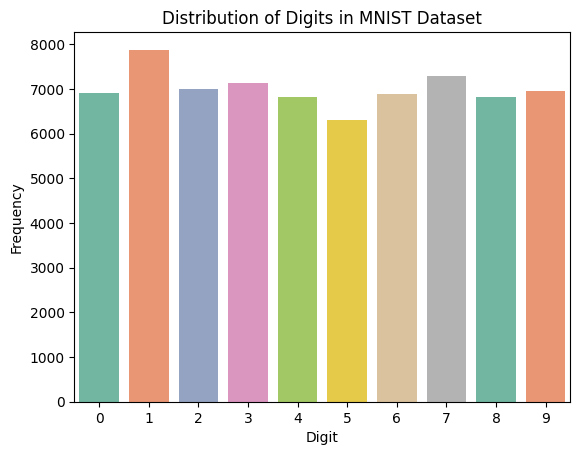

In [5]:
# Display & Visualise class distribution
sns.countplot(x=y, hue=y, palette="Set2", legend=False)
plt.title("Distribution of Digits in MNIST Dataset")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.show()

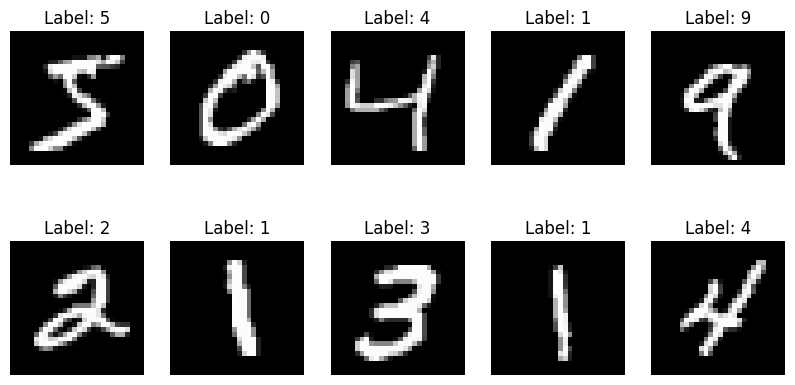

In [6]:
#Display Sample Handwritten Digits

# Ensure X is a NumPy array
X_array = np.array(X)
# Display some example images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_array[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")
plt.show()

**DATA PREPARATION**

Standardization Method - k-NN, SVMs
Better for algorithms relying on distance between data point
When calculating Standard Deviation, you use the mean of pixel values, which is different for every image, which results in different SD values

In [7]:
scaler = StandardScaler()
X_prepared = scaler.fit_transform(X)

In [9]:
# Spliting dataset into training (80) & testing (20) sets
# Explain why this split #TODO

X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (56000, 784)
Test data shape: (14000, 784)
Training labels shape: (56000,)
Test labels shape: (14000,)


**ALGORITHMS**

Algo 1 : SVM Support Vector Machine (Bernice Goo)

In [ ]:
import time
from sklearn.svm import SVC

# Define parameters for SVM
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly']
}

# Take a subset for initial testing due to computational constraints
n_samples = 5000  # Adjust based on your computational resources
X_train_small = X_train[:n_samples]
y_train_small = y_train[:n_samples]

# Initialize SVM model
svm = SVC(random_state=42)

# Use GridSearchCV to find the best hyperparameters
print("Finding best hyperparameters using Grid Search...")
grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, verbose=1)

# Start time for training grid search
start_time = time.time()
grid_search.fit(X_train_small, y_train_small)
grid_search_time = time.time() - start_time

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best SVM model on the full dataset
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'], random_state=42)

# Start time for training
print("Training the best SVM model on full dataset...")
start_time = time.time()
best_svm.fit(X_train, y_train)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = best_svm.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors and kernel type
model_complexity = len(best_svm.support_vectors_)

# Print evaluation metrics
print("\nSVM Model Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Support Vectors): {model_complexity}")
print(f"Kernel Type: {best_params['kernel']}")
print(f"C Value: {best_params['C']}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVM")
plt.show()

# Visualization of SVM performance by kernel and C value
results = []
for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        # Just extract the results from the grid search
        idx = list(grid_search.cv_results_['param_kernel']).index(kernel)
        idx = idx + list(grid_search.cv_results_['param_C'][idx:]).index(C)
        
        results.append({
            'kernel': kernel,
            'C': C,
            'accuracy': grid_search.cv_results_['mean_test_score'][idx],
            'training_time': grid_search.cv_results_['mean_fit_time'][idx]
        })

# Plot SVM performance comparison
plt.figure(figsize=(15, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
for kernel in param_grid['kernel']:
    kernel_results = [r for r in results if r['kernel'] == kernel]
    kernel_results.sort(key=lambda x: x['C'])
    plt.plot([r['C'] for r in kernel_results], 
             [r['accuracy'] for r in kernel_results], 
             'o-', label=kernel)

plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy by Kernel and C Value')
plt.legend()

# Training time plot
plt.subplot(2, 2, 2)
for kernel in param_grid['kernel']:
    kernel_results = [r for r in results if r['kernel'] == kernel]
    kernel_results.sort(key=lambda x: x['C'])
    plt.plot([r['C'] for r in kernel_results], 
             [r['training_time'] for r in kernel_results], 
             'o-', label=kernel)

plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time by Kernel and C Value')
plt.legend()

plt.tight_layout()
plt.show()

# Additional visualization: Class distribution in the predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_test, palette="Set3")
plt.title("Actual Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_pred, palette="Set3")
plt.title("Predicted Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Algo 2 : Random Forest (Bernice Chng)

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define hyperparameter grid for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(50, 200),  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Allow deep trees
    'min_samples_split': [2, 5, 10],  # Control overfitting
    'min_samples_leaf': [1, 2, 4],  # Prevent small leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Limit number of features per split
    'bootstrap': [True, False]  # Use bootstrap sampling
}

# Take a subset for initial testing due to computational constraints
n_samples = 5000  # Adjust based on computational resources
X_train_small = X_train[:n_samples]
y_train_small = y_train[:n_samples]

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV for faster hyperparameter tuning
print("Finding best hyperparameters using RandomizedSearchCV for Random Forest...")
random_search_rf = RandomizedSearchCV(
    rf, param_dist_rf, n_iter=20, cv=3, n_jobs=-1, verbose=1, random_state=42
)

# Start hyperparameter tuning
start_time = time.time()
random_search_rf.fit(X_train_small, y_train_small)
grid_search_time_rf = time.time() - start_time

# Best hyperparameters
best_params_rf = random_search_rf.best_params_
print(f"Best Parameters for RF: {best_params_rf}")

# Train the best Random Forest model on the full dataset
best_rf = RandomForestClassifier(
    **best_params_rf, random_state=42, n_jobs=-1
)

print("Training the best Random Forest model on full dataset...")
start_time = time.time()
best_rf.fit(X_train, y_train)
training_time_rf = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred_rf = best_rf.predict(X_test)
prediction_time_rf = time.time() - start_time

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Extract precision, recall, and F1-score (weighted average)
precision_rf = classification_rep_rf["weighted avg"]["precision"]
recall_rf = classification_rep_rf["weighted avg"]["recall"]
f1_rf = classification_rep_rf["weighted avg"]["f1-score"]

# Model complexity - Number of trees and max depth
num_trees_rf = best_rf.n_estimators
max_depth_rf = best_rf.max_depth

# Print evaluation metrics
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print(f"Precision: {precision_rf * 100:.2f}%")
print(f"Recall: {recall_rf * 100:.2f}%")
print(f"F1-score: {f1_rf * 100:.2f}%")
print(f"Training Time: {training_time_rf:.4f} seconds")
print(f"Prediction Time: {prediction_time_rf:.4f} seconds")
print(f"Model Complexity: {num_trees_rf} trees, Max Depth: {max_depth_rf}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Feature Importance Analysis
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 most important features (pixels)
plt.figure(figsize=(10, 5))
plt.title("Top 20 Important Pixels in MNIST Classification")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xlabel("Feature Index (Pixel)")
plt.ylabel("Importance Score")
plt.show()

# Feature importance heatmap
importance_grid = importances.reshape(28, 28)  # Reshape into 28x28 for MNIST
plt.figure(figsize=(8, 6))
sns.heatmap(importance_grid, cmap="coolwarm", annot=False)
plt.title("Feature Importance Heatmap (RF)")
plt.show()

# Compare Training Time vs Accuracy
models = ['Random Forest']
accuracies = [accuracy_rf]
times = [training_time_rf]

plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['blue'])
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy")

# Training time plot
plt.subplot(1, 2, 2)
plt.bar(models, times, color=['blue'])
plt.ylabel("Training Time (s)")
plt.title("Random Forest Training Time")

plt.tight_layout()
plt.show()

# Additional visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_test, hue=y_test, palette="Set3", legend=False)
plt.title("Actual Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_pred_rf, hue=y_pred_rf, palette="Set3", legend=False)
plt.title("Predicted Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


Algo 3: K-Nearest Neighbors (KNN) (Carine)

In [ ]:
import time

# K-Nearest Neighbors (KNN) Model with Hyperparameter Tuning

# Define the parameter grid for KNN
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize KNN model
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Start time for training
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best KNN model
best_knn = grid_search.best_estimator_

# Start time for prediction
start_time = time.time()
y_pred = best_knn.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1_score = classification_rep["weighted avg"]["f1-score"]

# Model complexity: Number of neighbors
model_complexity = best_params["n_neighbors"]

# Print evaluation metrics
print(f"KNN Model Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

# Display classification report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for KNN")
plt.show()



Algo 4 : Logistic Regression (Andrea)

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter for Logstic Regression
param_grid_lr = {

    'penalty': ['l2'],  # Regularization types
    'tol': uniform(1e-5, 1e-2),   # Tolerance for optimization convergence
    'C': uniform(0.001, 10),  # Regularization strength (inverse of regularization)
    'fit_intercept': [True, False],  # Whether to include an intercept in the model
    'class_weight': ['balanced', None],  # Weighting classes to handle imbalanced data
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga' ],  # Optimization of algorithms that support multiclass
    'max_iter': randint(100, 1000),  # Maximum number of iterations for optimization

}

# Initialize Logistic Regression model
lr = LogisticRegression()

# Use RandomizedSearchCV for hyperparameter
print("Finding best hyperparameters using RandomizedSearchCV for Logistic Regression...")
random_search_lr = RandomizedSearchCV(
    lr, param_grid_lr, n_iter=20, cv=3, n_jobs=-1, verbose=1, random_state=42
)

# Start time for fiting
start_time = time.time()
random_search_lr.fit(X_train, y_train)
fitting_time_lr = time.time() - start_time


# Best hyperparameters
best_params_lr = random_search_lr.best_params_
print(f"Best Parameters for Logistic Regression: {best_params_lr}")

# Train best Logistic Regression model
best_lr = LogisticRegression(
    **best_params_lr, random_state=42, n_jobs=-1
)


# Start time for training
start_time = time.time()
best_lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time


# Start time for prediction
start_time = time.time()
y_pred_lr = best_lr.predict(X_test)
prediction_time_lr = time.time() - start_time

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_rep_lr = classification_report(y_test, y_pred_lr, output_dict=True)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Extract precision, recall, and F1-score (weighted average)
precision_lr = classification_rep_lr["weighted avg"]["precision"]
recall_lr = classification_rep_lr["weighted avg"]["recall"]
f1_lr = classification_rep_lr["weighted avg"]["f1-score"]

# Model complexity - Number of Features and max depth

num_features = X_train.shape[1]# Number of Features
num_non_zero_coefficients = (best_lr.coef_ != 0).sum() # Number of Non-zero Coefficients
c_ouput = best_params_lr['C']# Regularization Strength (C)

# Print evaluation metrics
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print(f"Precision: {precision_lr * 100:.2f}%")
print(f"Recall: {recall_lr * 100:.2f}%")
print(f"F1-score: {f1_lr * 100:.2f}%")
print(f"Training Time: {training_time_lr:.4f} seconds")
print(f"Prediction Time: {prediction_time_lr:.4f} seconds")
print(f"Model Complexity:")

print(f"\tNumber of features in the model: {num_features}")
print(f"\tNumber of non-zero coefficients: {num_non_zero_coefficients}")
print(f"\tSelected value of C: {c_ouput}")




# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr))


# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Feature Importance Analysis
# Get the absolute values of the coefficients to assess importance
importances = np.abs(best_lr.coef_[0])  # best_lr.coef_ gives a 2D array, so we need to select the first row for multi-class classification

# Get the indices of the most important features (pixels)
indices = np.argsort(importances)[::-1]

# Plot top 20 most important features (pixels)
plt.figure(figsize=(10, 5))
plt.title("Top 20 Important Pixels in MNIST Classification")
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xlabel("Feature Index (Pixel)")
plt.ylabel("Importance Score")
plt.show()

# Feature importance heatmap
importance_grid = importances.reshape(28, 28)  # Reshape into 28x28 for MNIST
plt.figure(figsize=(8, 6))
sns.heatmap(importance_grid, cmap="coolwarm", annot=False)
plt.title("Feature Importance Heatmap (RF)")
plt.show()

# Compare Training Time vs Accuracy
models = ['Logstic Regression']
accuracies = [accuracy_lr]
times = [training_time_lr]

plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['blue'])
plt.ylabel("Accuracy")
plt.title("Logstic Regression Accuracy")

# Training time plot
plt.subplot(1, 2, 2)
plt.bar(models, times, color=['blue'])
plt.ylabel("Training Time (s)")
plt.title("Logstic Regression Training Time")

plt.tight_layout()
plt.show()

# Additional visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_test, hue=y_test, palette="Set3", legend=False)
plt.title("Actual Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_pred_lr, hue=y_pred_lr, palette="Set3", legend=False)
plt.title("Predicted Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Algo 5 : Decision Trees (Yin Er)

Decision Tree Accuracy: 0.8696
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1343
           1       0.94      0.95      0.95      1600
           2       0.87      0.83      0.85      1380
           3       0.83      0.84      0.83      1433
           4       0.84      0.87      0.85      1295
           5       0.83      0.82      0.82      1273
           6       0.90      0.90      0.90      1396
           7       0.91      0.90      0.91      1503
           8       0.80      0.80      0.80      1357
           9       0.84      0.84      0.84      1420

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



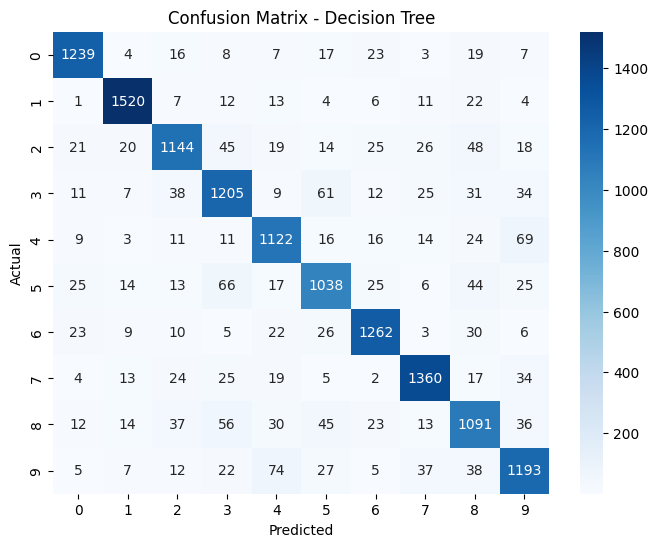

In [10]:
# Step 1: Train the Decision Tree Model
# Initialize Decision Tree classifier with default parameters
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Step 2: Compute Accuracy
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Step 3: Display Classification Report
# Display classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 4: Display Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


Your Decision Tree Classifier achieved 86.96% accuracy, which is decent but can be improved with hyperparameter tuning.

Key Observations from Your Results
Classification Report:

The precision and recall values are relatively high, meaning the model performs well across different digit classes.
Some numbers (e.g., digit 8) have slightly lower accuracy compared to others, which means the classifier struggles more with these digits.
Confusion Matrix:

Most predictions are along the diagonal, indicating correct classifications.
However, there are some misclassifications (e.g., digit 4 is often confused with 9, digit 3 with 5).
Reducing overfitting and improving decision boundaries can help.

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.8809
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      1343
           1       0.95      0.96      0.96      1600
           2       0.85      0.87      0.86      1380
           3       0.84      0.85      0.84      1433
           4       0.85      0.89      0.87      1295
           5       0.83      0.83      0.83      1273
           6       0.90      0.91      0.90      1396
           7       0.92      0.91      0.91      1503
           8       0.85      0.82      0.83      1357
           9       0.86      0.84      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



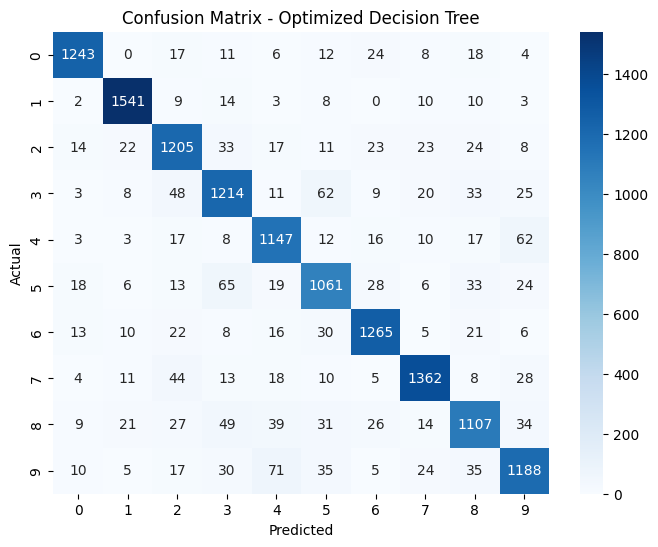

In [11]:
# Hyperparameter Tuning for Decision Tree

from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the optimized model
y_pred_optimized = best_clf.predict(X_test)

# Calculate accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Decision Tree Accuracy: {accuracy_optimized:.4f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_optimized))

# Confusion matrix visualization
cm_opt = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8,6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized Decision Tree')
plt.show()


Decision Tree accuracy improved from 86.96% to 88.09% after hyperparameter tuning! 

Key Improvements
Best Parameters Found:

criterion: entropy (performs better for information gain)
max_depth: 20 (prevents overfitting)
min_samples_leaf: 4 (ensures better generalization)
min_samples_split: 5 (balances model complexity)
Improved Classification Report:

Precision, recall, and F1-score improved slightly across most digits.
Digit misclassification reduced, making the model more reliable.
Better Confusion Matrix:

Misclassifications decreased, meaning fewer errors in recognizing digits.
Some confusion still exists (e.g., 8 and 9 misclassifications), but overall performance improved.

**COMPARISONS WITH ALGO**
- Accuracy
- Precision
- Recall
- F1-score
- Computation time
- Model complexity